# 미션 개요: FashionMNIST를 활용한 조건부 이미지 생성 (cGAN)

## 목표
FashionMNIST 데이터셋을 활용해 Conditional GAN(cGAN) 모델을 설계하고 학습.

## 데이터 소개
- **데이터셋:** FashionMNIST
- **훈련 데이터:** 60,000장  
- **테스트 데이터:** 10,000장  
- **이미지 크기:** 28 × 28 (흑백)  
- **클래스 수:** 10개  
- **클래스 목록:**
  1. T-shirt/top  
  2. Trouser  
  3. Pullover  
  4. Dress  
  5. Coat  
  6. Sandal  
  7. Shirt  
  8. Sneaker  
  9. Bag  
  10. Ankle boot  

## 주요 실습 내용
1. 데이터 로드 및 전처리
2. cGAN 모델 설계
3. 훈련
- 클래스 레이블을 이용해 각 클래스별 이미지 생성
4. 결과 분석 및 시각화


In [1]:
# @title 라이브러리

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1.데이터 로드 및 전처리

FashionMNIST는 28x28 흑백이미지 -> ToTensor, Normalize

In [2]:
# @title transform 정의

transform = transforms.Compose([
    transforms.ToTensor(),  # [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5))    # 평균 0.5, 표준편차 [-1, 1]
])

In [3]:
# @title 데이터셋 로드

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 26.4M/26.4M [00:01<00:00, 19.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.52MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.2MB/s]


In [4]:
# @title DataLoader 생성

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

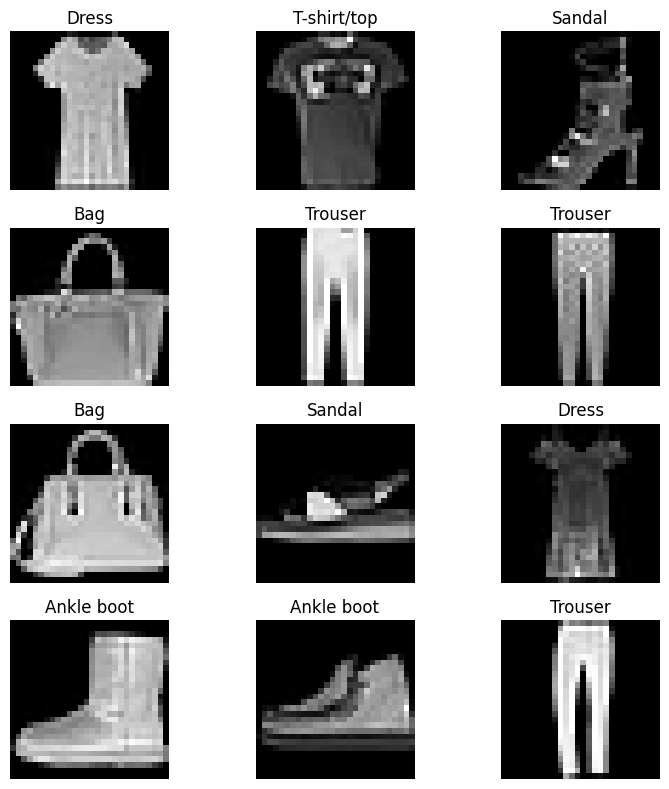

In [5]:
# @title 이미지 확인

classes = train_dataset.classes # 클래스명
idx_to_class = {i: c for i, c in enumerate(train_dataset.classes)}

def unnormalize(image):
    return image * 0.5 + 0.5

def show_images(loader, n):
    images, labels = next(iter(loader))
    if n > len(images):
        n = len(images)
    elif n <= 0:
        n = 1
    images = images[:n]
    labels = labels[:n]

    cols = 3
    rows = math.ceil(n / cols)

    plt.figure(figsize=(8, 8))
    # plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        image = unnormalize(images[i]).squeeze()
        plt.imshow(image, cmap='gray')
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(train_loader, 12)

# 2.cGAN 모델 설계

- Generator: noise(z) + label 정보를 결합해 이미지 생성
- Discriminator: 진짜/가짜 이미지 + label 정보를 함께 보고 판별

----

## Generator
- 입력: noise vector z + class label (one-hot or embedding)
- 출력: 28x28 흑백 이미지

- z_dim: Latent Vector Dimension(보통 100)
 - Generator의 입력이 되는 노이즈 벡터의 차원 수
 - 생성하고자 하는 이미지의 다양성을 담아내는 핵심 요소
 - 보통 100. 너무 작으면 다양성 부족, 너무 크면 학습 어려움

- embedding_Dim: 클래스 임베딩 차원 수
 - 정수형 클래스 레이블(0~9)을 벡터로 바꿔주는 임베딩 차원의 크기
 - 조건 정보(클래스)를 더 풍부하게 표현하는 역할
 - 값이 너무 작으면 클래스 정보 부족하게 전달
 - 너무 크면 학습이 불안정해지거나 오버파라미터 문제 생김
 - 보통 10~100 사이

- hidden_dim: 중간 레이어의 뉴런 수(네트워크 크기)
 - Generator나 Discriminator 내부의 중간 레이어 크기
 - 모델의 표현력(복잡한 패턴을 표현하는 능력) 결정
 - 크면 학습 능력은 높아지지만, 과적합 및 속도 문제 가능
 - 작으면 학습이 너무 단순해서 이미지 품질이 낮을 수 있음
 - 학습이 너무 느리면 줄이고, 성능이 낮다면 키우면서 조절


## Discriminator
- 입력: 이미지 + 클래스 정보
- 출력: 이미지가 진짜인지 가짜인지에 대한 확률

In [6]:
image_size = 28 * 28
num_classes = len(idx_to_class)
z_dim = 100
embedding_dim = 10
hidden_dim = 256

In [7]:
# @title Generator

class Generator(nn.Module):
    def __init__(self, z_dim, embedding_dim, num_classes, img_channels=1, feature_maps=128):
       super().__init__()
       self.label_emb = nn.Embedding(num_classes, embedding_dim)


       self.init_size = 8
       self.feature_maps = feature_maps

       self.linear1 = nn.Sequential(
           nn.Linear(z_dim + embedding_dim, feature_maps * self.init_size ** 2),
           nn.BatchNorm1d(feature_maps * self.init_size ** 2),
           nn.ReLU(True)
       )

       self.conv_blocks = nn.Sequential(
           nn.Upsample(scale_factor=2),     # 8 -> 16
           nn.Conv2d(feature_maps, feature_maps // 2, kernel_size=3, stride=1, padding=1),
           nn.BatchNorm2d(feature_maps // 2, momentum=0.8),
           nn.ReLU(True),

           nn.Upsample(scale_factor=2),     # 16 -> 32
           nn.Conv2d(feature_maps // 2, feature_maps // 4, kernel_size=3, stride=1, padding=1),
           nn.BatchNorm2d(feature_maps // 4, momentum=0.8),
           nn.ReLU(True),

           nn.Conv2d(feature_maps // 4, img_channels, kernel_size=5, stride=1, padding=0),  # 32 -> 28
           nn.Tanh()
       )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        out = self.linear1(x)
        out = out.view(out.size(0), self.feature_maps, self.init_size, self.init_size)
        return self.conv_blocks(out)    # img

In [8]:
# @title Discriminator

class Discriminator(nn.Module):
    def __init__(self, embedding_dim, num_classes, img_channels=1, feature_maps=128):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.feature_maps = feature_maps

        self.label_fc = nn.Sequential(
            nn.Linear(embedding_dim, 28*28),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.model = nn.Sequential(
            nn.Conv2d(img_channels + 1, feature_maps, kernel_size=3, stride=2, padding=1),  # 28 -> 14
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(0.3),  # 추가

            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=3, stride=2, padding=1),  # 14 -> 7
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),   # [batch, feature_maps*2*7*7]
            nn.Linear(feature_maps * 2 * 7 * 7, 1),
            # nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label_embedding = self.label_emb(labels)

        # (batch, 1, 28, 28) reshape
        # label_map = label_embedding.view(batch_size, 1, 1, 1).expand(-1, 1, 28, 28)
        # label_map = label_embedding.unsqueeze(2).unsqueeze(3).expand(-1, -1, 28, 28)
        label_map = self.label_fc(label_embedding)
        label_map = label_map.view(batch_size, 1, 28, 28)
        d_in = torch.cat((img, label_map), dim=1)   # shape: (batch, 2, 28, 28)
        return self.model(d_in)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
# @title model 초기화

G = Generator(z_dim=z_dim, embedding_dim=embedding_dim, num_classes=num_classes).to(device)
D = Discriminator(embedding_dim, num_classes).to(device)


# 3.조건부 학습

## 1차 결과
| Epoch | Discriminator Loss (Loss_D) | Generator Loss (Loss_G) |
|-------|-----------------------------|------------------------|
| 1     | 0.6157                      | 1.7088                 |
| 10    | 0.3786                      | 2.7560                 |
| 20    | 0.3951                      | 2.7920                 |
| 30    | 0.4707                      | 2.4216                 |
| 40    | 0.4519                      | 2.6142                 |
| 50    | 0.4133                      | 2.8356                 |

- 초반 10 epoch까지는 Discriminator 손실이 크게 감소. Generator 손실은 상승. -> Generator가 더 잘 학습
- 10 ~ 20 epoch 사이에 Discriminator 손실이 다소 증가하는 현상. Generator 손실은 어느 정도 유지
- 20 ~ 30 epoch 구간에서 Generator 손실이 감소하는 현상 잠시 -> 다시 상승
- 전반적으로 Generator 손실이 점진적으로 증가하는 구간이 있으나, 다시 상승세로 마무리

### 결과 해석
- Discriminator 손실이 너무 낮으면 Generator가 학습하기 어렵고, 반대로 Discriminator 손실이 너무 높으면 Discriminator가 제대로 학습하지 못하는 상태
- Generator 손실이 크게 변동하면서도 전반적으로 높은 편으로 안정적인 학습이 아직 부족함
- Generator와 Discriminator 간 힘의 균형이 완벽하지 않은 상태로 보임(Mode collapse 가능성 및 과적합 가능성 존재)

### 개선 방안
- 학습률, 배치 크기 등 하이퍼파라미터 튜닝 시도
- Generator 및 Discriminator 네트워크 구조에 BatchNorm, Dropout 등 정규화 기법 추가 고려
- 레이블 임베딩 및 조건부 입력 방식 개선
- 데이터 증강 적용으로 학습 데이터 다양성 확보

## 2차 결과
- embedding_dim : 1 -> 50
- Discriminator에 dropout 추가

| Epoch | Discriminator Loss (Loss_D) | Generator Loss (Loss_G) |
|-------|-----------------------------|------------------------|
| 1     | 0.8312                      | 1.3143                 |
| 10    | 0.4946                      | 2.2066                 |
| 20    | 0.4042                      | 2.6677                 |
| 30    | 0.3400                      | 2.9093                 |
| 40    | 0.3630                      | 2.9196                 |
| 50    | 0.3250                      | 3.2461                 |

- 초반 Discriminator 손실이 1차보다 높게 시작했지만, 점차 안정적으로 감소
- Generator 손실이 전반적으로 꾸준히 상승
- Discriminator도 강력해져서 Generator가 Discriminator를 쉽게 속이지 못해 loss가 상대적으로 높게 나올 수 있음

### 결과 해석
- embedding_dim을 키워서 레이블 임베딩이 더 풍부해져 Generator가 조건을 더 잘 반영
- Discriminator가 안정적으로 학습하면서 Generator의 성능도 개선
- 1차보다 힘의 균형이 더 잘맞춰진 상태로 판단

## 3차 결과
- embedding_dim 50 -> 10
- trainloader batch_size 128 -> 64
- Discriminator Dropout 제거

| Epoch | Loss_D | Loss_G |
|-------|--------|--------|
| 1     | 0.5209 | 1.8787 |
| 10    | 0.6562 | 1.8203 |
| 20    | 0.5606 | 2.1760 |
| 30    | 0.4623 | 2.5371 |
| 40    | 0.4019 | 2.8864 |
| 50    | 0.3391 | 3.2405 |

- 초반 Generator 손실이 잠시 줄었다가 이후 다시 상승
- Discriminator 손실은 1차보다 낮고, 2차보다 일정한 하강세를 보임

### 결과 해석
- embedding_dim을 적절히 키우면 Generator가 조건 정보를 더 잘 반영
- batch_size 감소는 전반적으로 손실 값들이 조금 더 세밀하게 반응하도록 도와 학습 곡선 완만해짐

### 문제점
- 형태 왜곡: 일부 클래스(T-shirt, Shirt 등)의 모양이 뭉개지거나 불분명
- 디테일 부족
- 클래스 간 유사성: (T-shirt, Shirt), (Sneaker, Ankle boot) 등의 구분이 흐려질 가능성 있음

## 4차 결과
- feature_map 64 -> 128
- conv 채널 init_size 7 -> 8
- loss BCELoss -> Hinge Loss
- epoch 50 -> 80

| Epoch 범위 | Generator Loss (평균) | Discriminator Loss (평균) |
|------------|------------------------|----------------------------|
| 1~10       | 0.53 ~ 0.86            | 1.20 ~ 1.36                |
| 11~30      | 0.55 ~ 0.71            | 1.30 ~ 1.20                |
| 31~60      | 0.70 ~ 1.01            | 1.10 ~ 0.94                |
| 61~80      | 1.06 ~ 1.17            | 0.93 ~ 0.83                |


### 결과 해석
- Hinge Loss 도입과 모델 용량 증가로 생성 품질 향상에 유의미한 효과
- 일부 클래스 (Sandal, Bag 등) 여전히 저해상도 디테일 부족


In [11]:
# @title 손실함수 설정
"""
    Generator는 Discriminator를 속이려고 하고,
    Discriminator는 진짜/가짜를 구분하려고 함
    BCELoss 사용 (이진분류) : real 1, fake 0
"""

criterion = nn.BCELoss()

def hinge_loss_discriminator(real_scores, fake_scores):
    loss_real = torch.mean(torch.relu(1.0 - real_scores))
    loss_fake = torch.mean(torch.relu(1.0 + fake_scores))
    return loss_real + loss_fake

def hinge_loss_generator(fake_scores):
    return -torch.mean(fake_scores)

In [12]:
# @title Optimizer 설정
"""
    Adam optimizer -> 모멘텀 개념 사용
    지수 이동 평균(decay rate)의 비율을 batas=(beta1, beta2)
    beta1: 이전 그래디언트 방향(모멘텀)의 평균 정도 (기본값 0.9)
    beta2: 그래디언트 제곱의 평균(스케일)의 유지 정도 (기본값 0.999)

    GAN은 불안정하고, 발산하거나 모드 붕괴 발생 가능 -> 기존보다 더 빠르게 적응하도록 beta1 값을 낮게 설정
    beta1 = 0.5 : 이전 방향을 반영하되, 빠르게 새로운 방향으로 적응하게 함 (더 민감하고 빠른 업데이트 가능)
                    불안정한 GAN 훈련에서 더 안정적인 수렴을 유도

"""
LR = 0.0002
beta1 = 0.5

optimizer_G = optim.Adam(G.parameters(), lr=LR, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=LR, betas=(beta1, 0.999))


[Epoch 1/80] Loss_D: 0.8269 | Loss_G: 0.9323
[Epoch 2/80] Loss_D: 1.2151 | Loss_G: 0.6197
[Epoch 3/80] Loss_D: 1.2644 | Loss_G: 0.6108
[Epoch 4/80] Loss_D: 1.2865 | Loss_G: 0.6037
[Epoch 5/80] Loss_D: 1.2980 | Loss_G: 0.5804
[Epoch 6/80] Loss_D: 1.3021 | Loss_G: 0.5804
[Epoch 7/80] Loss_D: 1.3091 | Loss_G: 0.5838
[Epoch 8/80] Loss_D: 1.3135 | Loss_G: 0.5733
[Epoch 9/80] Loss_D: 1.3216 | Loss_G: 0.5918
[Epoch 10/80] Loss_D: 1.3170 | Loss_G: 0.5912


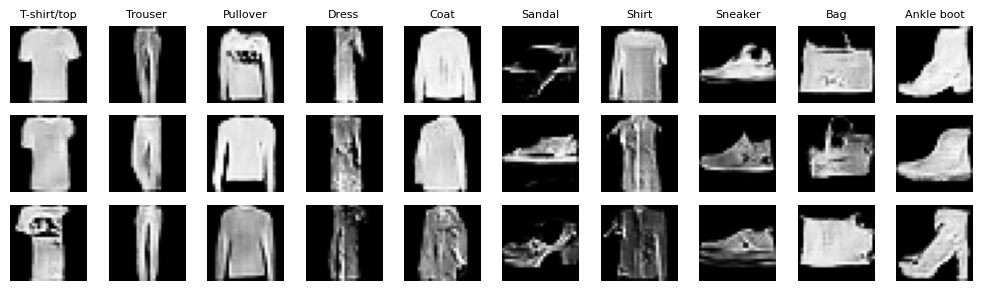

[Epoch 11/80] Loss_D: 1.3205 | Loss_G: 0.5890
[Epoch 12/80] Loss_D: 1.3080 | Loss_G: 0.5732
[Epoch 13/80] Loss_D: 1.3065 | Loss_G: 0.5844
[Epoch 14/80] Loss_D: 1.2994 | Loss_G: 0.6037
[Epoch 15/80] Loss_D: 1.2941 | Loss_G: 0.6097
[Epoch 16/80] Loss_D: 1.2834 | Loss_G: 0.6070
[Epoch 17/80] Loss_D: 1.2873 | Loss_G: 0.6152
[Epoch 18/80] Loss_D: 1.2819 | Loss_G: 0.6165
[Epoch 19/80] Loss_D: 1.2693 | Loss_G: 0.6281
[Epoch 20/80] Loss_D: 1.2619 | Loss_G: 0.6329


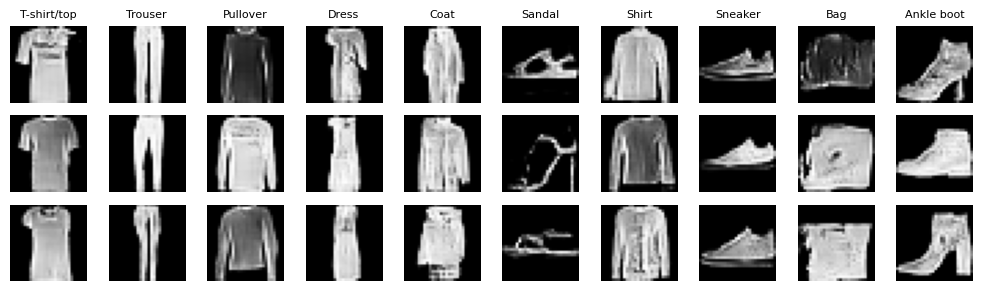

[Epoch 21/80] Loss_D: 1.2675 | Loss_G: 0.6408
[Epoch 22/80] Loss_D: 1.2444 | Loss_G: 0.6492
[Epoch 23/80] Loss_D: 1.2401 | Loss_G: 0.6585
[Epoch 24/80] Loss_D: 1.2337 | Loss_G: 0.6625
[Epoch 25/80] Loss_D: 1.2234 | Loss_G: 0.6616
[Epoch 26/80] Loss_D: 1.2202 | Loss_G: 0.6713
[Epoch 27/80] Loss_D: 1.2026 | Loss_G: 0.6899
[Epoch 28/80] Loss_D: 1.2033 | Loss_G: 0.7081
[Epoch 29/80] Loss_D: 1.1919 | Loss_G: 0.7056
[Epoch 30/80] Loss_D: 1.1742 | Loss_G: 0.7243


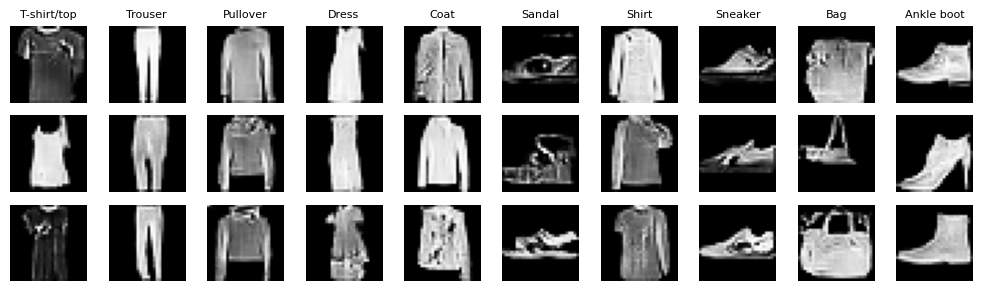

[Epoch 31/80] Loss_D: 1.1745 | Loss_G: 0.7315
[Epoch 32/80] Loss_D: 1.1575 | Loss_G: 0.7354
[Epoch 33/80] Loss_D: 1.1569 | Loss_G: 0.7464
[Epoch 34/80] Loss_D: 1.1531 | Loss_G: 0.7556
[Epoch 35/80] Loss_D: 1.1484 | Loss_G: 0.7747
[Epoch 36/80] Loss_D: 1.1274 | Loss_G: 0.7750
[Epoch 37/80] Loss_D: 1.1192 | Loss_G: 0.7930
[Epoch 38/80] Loss_D: 1.1080 | Loss_G: 0.7939
[Epoch 39/80] Loss_D: 1.1029 | Loss_G: 0.8018
[Epoch 40/80] Loss_D: 1.0919 | Loss_G: 0.8092


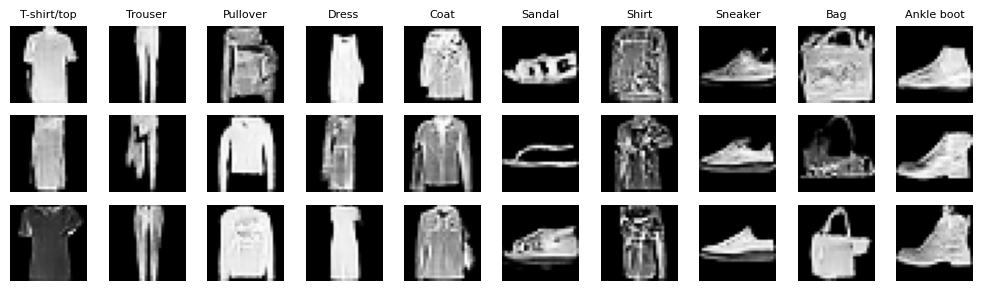

[Epoch 41/80] Loss_D: 1.0961 | Loss_G: 0.8187
[Epoch 42/80] Loss_D: 1.0714 | Loss_G: 0.8419
[Epoch 43/80] Loss_D: 1.0593 | Loss_G: 0.8544
[Epoch 44/80] Loss_D: 1.0522 | Loss_G: 0.8687
[Epoch 45/80] Loss_D: 1.0351 | Loss_G: 0.8771
[Epoch 46/80] Loss_D: 1.0227 | Loss_G: 0.8911
[Epoch 47/80] Loss_D: 1.0208 | Loss_G: 0.9114
[Epoch 48/80] Loss_D: 1.0041 | Loss_G: 0.9227
[Epoch 49/80] Loss_D: 1.0056 | Loss_G: 0.9262
[Epoch 50/80] Loss_D: 0.9841 | Loss_G: 0.9443


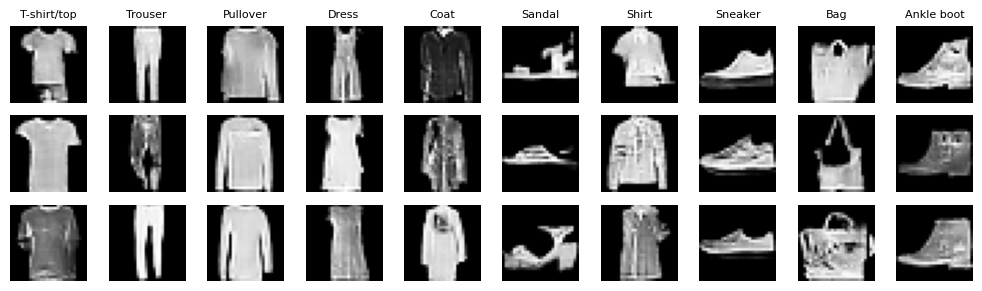

[Epoch 51/80] Loss_D: 0.9703 | Loss_G: 0.9554
[Epoch 52/80] Loss_D: 0.9632 | Loss_G: 0.9722
[Epoch 53/80] Loss_D: 0.9423 | Loss_G: 1.0044
[Epoch 54/80] Loss_D: 0.9413 | Loss_G: 1.0021
[Epoch 55/80] Loss_D: 0.9364 | Loss_G: 1.0234
[Epoch 56/80] Loss_D: 0.9246 | Loss_G: 1.0353
[Epoch 57/80] Loss_D: 0.9197 | Loss_G: 1.0339
[Epoch 58/80] Loss_D: 0.9161 | Loss_G: 1.0481
[Epoch 59/80] Loss_D: 0.9083 | Loss_G: 1.0637
[Epoch 60/80] Loss_D: 0.8909 | Loss_G: 1.0741


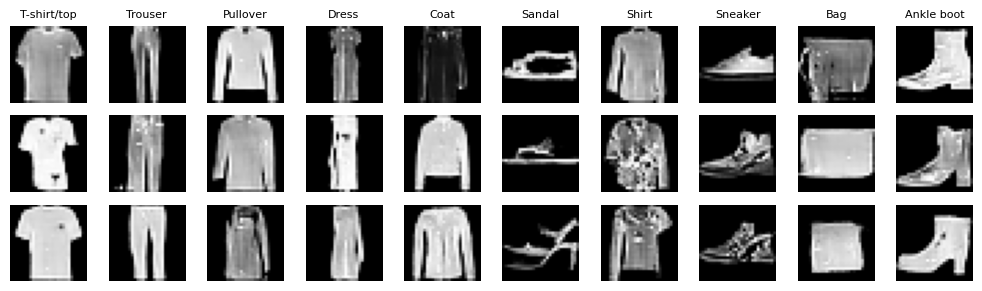

[Epoch 61/80] Loss_D: 0.8877 | Loss_G: 1.0800
[Epoch 62/80] Loss_D: 0.8840 | Loss_G: 1.0982
[Epoch 63/80] Loss_D: 0.8820 | Loss_G: 1.1059
[Epoch 64/80] Loss_D: 0.8833 | Loss_G: 1.0976
[Epoch 65/80] Loss_D: 0.8643 | Loss_G: 1.1009
[Epoch 66/80] Loss_D: 0.8645 | Loss_G: 1.1154
[Epoch 67/80] Loss_D: 0.8614 | Loss_G: 1.1291
[Epoch 68/80] Loss_D: 0.8571 | Loss_G: 1.1473
[Epoch 69/80] Loss_D: 0.8557 | Loss_G: 1.1399
[Epoch 70/80] Loss_D: 0.8458 | Loss_G: 1.1638


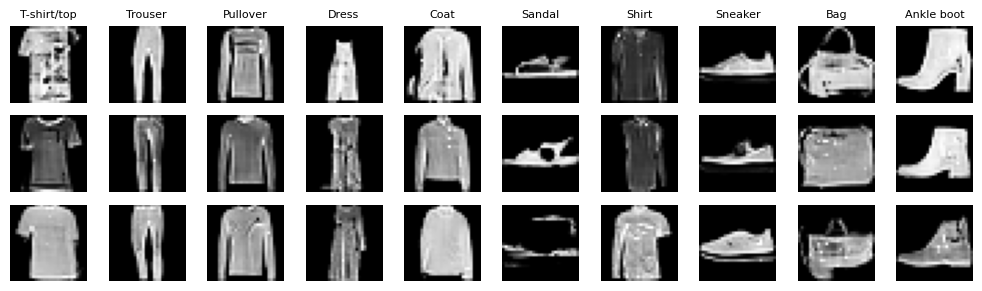

[Epoch 71/80] Loss_D: 0.8406 | Loss_G: 1.1758
[Epoch 72/80] Loss_D: 0.8378 | Loss_G: 1.1680
[Epoch 73/80] Loss_D: 0.8356 | Loss_G: 1.1856
[Epoch 74/80] Loss_D: 0.8180 | Loss_G: 1.1959
[Epoch 75/80] Loss_D: 0.8197 | Loss_G: 1.1903
[Epoch 76/80] Loss_D: 0.8128 | Loss_G: 1.2200
[Epoch 77/80] Loss_D: 0.8031 | Loss_G: 1.2287
[Epoch 78/80] Loss_D: 0.8047 | Loss_G: 1.2381
[Epoch 79/80] Loss_D: 0.7960 | Loss_G: 1.2431
[Epoch 80/80] Loss_D: 0.7913 | Loss_G: 1.2397


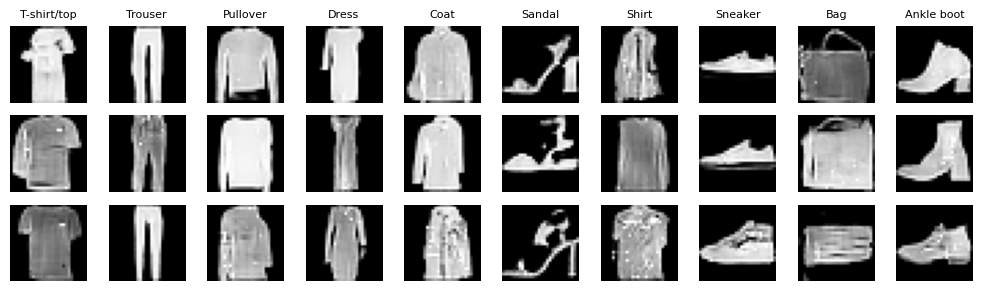

In [13]:
# @title 학습 루프

"""
    1. 진짜 이미지 D 학습
    2. 가짜 이미지 D 학습
    3. G는 D를 속이도록 학습
    (조건에 클래스 레이블)
"""

epochs = 80

for epoch in range(epochs):
    loss_D_total = 0
    loss_G_total = 0
    for real_imgs, labels in train_loader:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)    # (batch, 1, 28, 28)
        labels = labels.to(device)

        # 진짜 / 가짜 라벨
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # 1. Discriminator
        # 진짜 이미지 판별
        real_out = D(real_imgs, labels)
        # real_loss_d = criterion(real_out, real)

        # 가짜 이미지 생성
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z, labels)

        # 가짜 이미지 판별
        fake_out = D(fake_imgs.detach(), labels)
        # fake_loss_d = criterion(fake_out, fake)

        # Discriminator 손실값 계산
        # loss_d = real_loss_d + fake_loss_d
        loss_d = hinge_loss_discriminator(real_out, fake_out)
        optimizer_D.zero_grad()
        loss_d.backward()
        optimizer_D.step()

        # 2. Generator

        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z, labels)
        output = D(fake_imgs, labels)

        # loss_g = criterion(output, real)  # Generator는 Discriminator 속이는 것이 목적
        loss_g = hinge_loss_generator(output)
        optimizer_G.zero_grad()
        loss_g.backward()
        optimizer_G.step()

        loss_D_total += loss_d.item()
        loss_G_total += loss_g.item()

    # === epoch마다 평균 손실 출력 ===
    print(f"[Epoch {epoch+1}/{epochs}] Loss_D: {loss_D_total/len(train_loader):.4f} | Loss_G: {loss_G_total/len(train_loader):.4f}")

    if (epoch+1) % num_classes == 0:
        G.eval()
        n_row = 3
        n_col = num_classes
        total = n_row * n_col

        # 생성 noise 및 조건 레이블
        z = torch.randn(total, z_dim).to(device)
        labels_sample = torch.arange(0, num_classes).repeat(n_row).to(device)
        generate_imgs = G(z, labels_sample).detach().cpu()

        fig, axs = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
        for i in range(n_row):
            for j in range(n_col):
                idx = i * n_col + j
                axs[i, j].imshow(generate_imgs[idx][0], cmap='gray')
                axs[i, j].axis('off')
                if i == 0:
                    axs[i, j].set_title(idx_to_class[j], fontsize=8)

        plt.tight_layout()
        plt.show()
        G.train()

In [14]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = '/content/drive/MyDrive/codeit_sprint/sprint_mission/16/model'
import os;

os.makedirs(SAVE_DIR, exist_ok=True)

# 학습 완료 후 모델 저장
torch.save(G.state_dict(), f"{SAVE_DIR}/mission_16_cgan_gen.pth")
print(f"✔️ Generator 모델 저장 완료: {SAVE_DIR}/mission_16_cgan_gen.pth")

# 필요하다면 Discriminator도 함께 저장
torch.save(D.state_dict(), f"{SAVE_DIR}/mission_16_cgan_disc.pth")
print(f"✔️ Discriminator 모델 저장 완료: {SAVE_DIR}/mission_16_cgan_disc.pth")


Mounted at /content/drive
✔️ Generator 모델 저장 완료: /content/drive/MyDrive/codeit_sprint/sprint_mission/16/model/mission_16_cgan_gen.pth
✔️ Discriminator 모델 저장 완료: /content/drive/MyDrive/codeit_sprint/sprint_mission/16/model/mission_16_cgan_disc.pth


In [16]:
torch.save(G, f"{SAVE_DIR}/mission_16_cgan_gen_full.pth")
torch.save(D, f"{SAVE_DIR}/mission_16_cgan_disc_full.pth")

print("✅ 모델 전체 저장 완료!")

✅ 모델 전체 저장 완료!


# 4.결과 분석 및 시각화

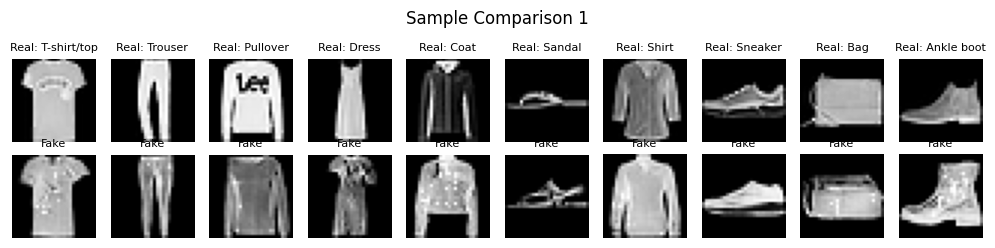

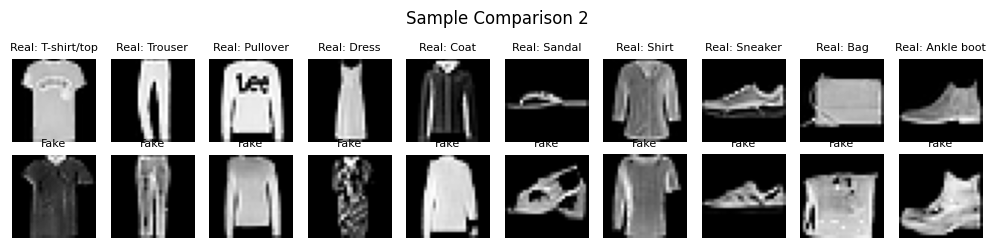

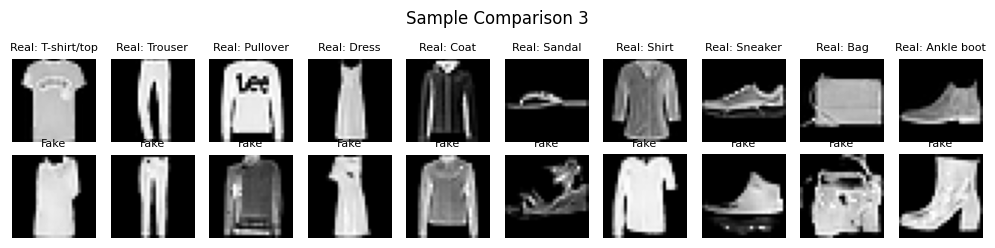

In [ ]:
# @title test: 전체 클래스별 비교 시각화 3회 반복

G.eval()
with torch.no_grad():
    repeat_n = 3  # 반복 횟수

    for rep in range(repeat_n):
        # 각 클래스마다 하나씩 모으기 위한 딕셔너리
        real_per_class = {}
        fake_per_class = {}

        for real_imgs, labels in test_loader:
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)

            for i in range(real_imgs.size(0)):
                label = labels[i].item()
                if label not in real_per_class:
                    # 진짜 이미지 저장
                    real_per_class[label] = real_imgs[i].unsqueeze(0)  # shape: (1, 1, 28, 28)
                    # 가짜 이미지 생성
                    z = torch.randn(1, z_dim).to(device)
                    fake_img = G(z, torch.tensor([label], device=device))
                    fake_per_class[label] = fake_img.detach().cpu()

                if len(real_per_class) == num_classes:  # 10개 모이면 종료
                    break
            if len(real_per_class) == num_classes:
                break

        # 시각화
        fig, axs = plt.subplots(2, num_classes, figsize=(num_classes, 2.5))
        for i in range(num_classes):
            axs[0, i].imshow(real_per_class[i][0][0].cpu(), cmap='gray')
            axs[0, i].set_title(f"Real: {idx_to_class[i]}", fontsize=8)
            axs[0, i].axis('off')

            axs[1, i].imshow(fake_per_class[i][0][0], cmap='gray')
            axs[1, i].set_title(f"Fake", fontsize=8)
            axs[1, i].axis('off')

        plt.suptitle(f"Sample Comparison {rep+1}", fontsize=12)
        plt.tight_layout()
        plt.show()


## 결과

- FashionMNIST의 10개 클래스를 반영하는 이미지를 생성하는 데 성공(전반적인 형태 및 질감이 실제 이미지와 유사함을 확인할 수 있었음)

- Trouser, Pullover, Sneaker, Ankle boot 등의 클래스에서 Real과 Fake 간 차이거 적음
- T-shirt/top, Shirt 등의 상체 의류 쪽은 팔 부분이 뭉개지거나 디테일 표현이 부족. Bag 클래스는 형태는 유사하지만 질갑 표현이 단조로운 한계

- 일부 클래스 간 유사도로 인해 조건 레이블이 잘 분리되지 않거나, Generator가 세밀한 구조까지ㅈ 학습하는데 어려움을 겪고 있음